# Figure 3 - Toy Model 
Anna Mackie, 2022

In this script, demonstrate the impact of non-linearites in the R function on the size of the dynamic effect.

Please see note in firstFig.ipynb for explanation of dA(w) and R(w) calculation

1. Create a typical dA
2. Create a typical R defined by two paramaters 
3. Look at how dynamic effect varies with the two paramaters

Refers to equation (3) in the paper

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
from matplotlib.ticker import FormatStrFormatter
import sys
sys.path.append('..')
import funcs
plt.rcParams['axes.unicode_minus'] = False

def makeGauss(x, mean, stddev):
    A1 = stats.norm(mean, stddev).pdf(x)
    return A1/np.sum(A1)

pl = 0.22 # pos limit
nlim= -0.07 # neg limit
bs = 0.001 # bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
mnbin = [] # create array of the mid-point between bin limits for plotting
for i in range(1,b):
    mnbin = np.append(mnbin, np.mean([bins[i-1], bins[i]]))    

   
mnbin = (mnbin+0.0005)*100 # nicer x axis and into cm
pLev = 500 # level in hPa used 

/home/users/arm33/RCEMIP/allMod/../funcs.py:128: RuntimeWarning: Mean of empty slice
  arrbin = [np.nanmean(arr[dig==i]) for i in range(1,b)]


inflection point in real R:  1.2000000000000066 m/s


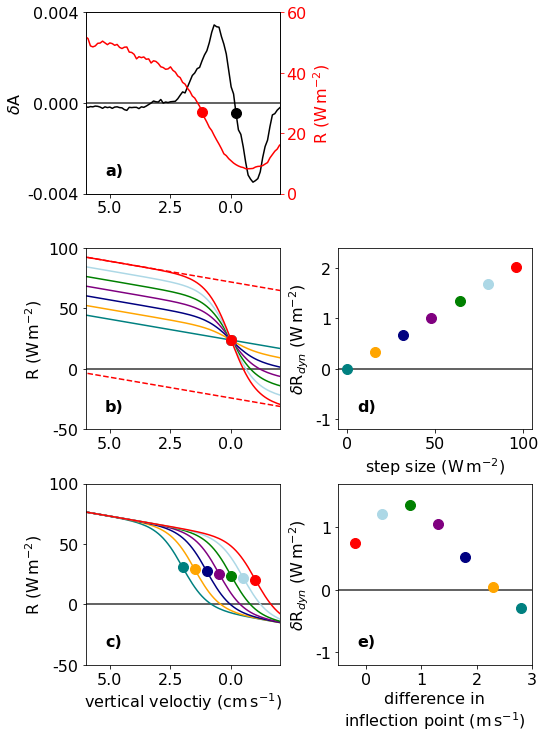

In [5]:
lets = ['a)', 'b)', 'c)', 'd)', 'e)']

#use a real dA from SAM_CRM_large300 and SAM_CRM_large305
dp = '/home/users/arm33/RCEMIP/SAM_CRM/processed_new/2D/'
dp2 = '/home/users/arm33/RCEMIP/SAM_CRM/processed_new/3D/'

#load wa5001, wa5002 and lwcrf1. Create R and A functions
lwcrf1 = np.load(dp + 'large300lwcrf24hrs.npy', allow_pickle = True) 

wa = np.load(dp2 + 'large300wa_profile_25d.npy', allow_pickle = True)
pa = np.load(dp2 + 'large300pa_profile_25d.npy', allow_pickle = True)/100
wa5001 = funcs.getPlevel(wa, pa, pLev)

wa = np.load(dp2 + 'large305wa_profile_25d.npy', allow_pickle = True)
pa = np.load(dp2 + 'large305pa_profile_25d.npy', allow_pickle = True)/100
wa5002 = funcs.getPlevel(wa, pa, pLev)

dig1 = np.digitize(wa5001, bins)
A1 = funcs.createA(dig1, b)
dig2 = np.digitize(wa5002, bins)
A2 = funcs.createA(dig2, b)

Rreal = funcs.createR(lwcrf1, dig1, b)
dA = (A2 - A1)

#set up figure
l = len(mnbin)
cols = ['teal', 'orange', 'navy', 'purple', 'green', 'lightblue', 'red']
ms = 10 # marker size

fig  = plt.figure()
ax1 = fig.add_subplot(321)
ax3 = fig.add_subplot(323)
ax9 = fig.add_subplot(325)
ax4 = fig.add_subplot(324)
ax10 = fig.add_subplot(326)

xlim = [6,-2]
ylim= [-50,100]

c=0   
for ax in [ax1, ax3, ax9, ax4, ax10]:
    ax.text(0.1, 0.1, lets[c], fontweight = 'bold',transform=ax.transAxes)
    c+=1
  
# smooth the real dA and R for this idealised experiment
"""The R function is quite noisy, and we want to focus on the inflection point near zero, rather than picking up 
a point in at an extreme value of vertical velocity. This involves restricting the part of the x axis which we 
search for an inflection point"""
n = 14 # number of points used for running mean
nh = int(n/2)
mnbinR = mnbin[nh-1:-nh]

# inflectiom point in dA(w)

dAS = funcs.running_mean(dA, n)#smooth dA using running mean
spldA = UnivariateSpline(mnbinR, dAS, k=4, s=0) # use spline and derivative to find the inflection point
spldA1 = spldA.derivative()
maxdA= np.argmax(spldA1(mnbinR)) # inflection point

# inflection point in R(w)
Rreal = funcs.running_mean(Rreal, n) #smooth real R

# focus on the region around zero to find that inflection point
lower_lim = np.argmin(np.abs(mnbin+1.5))
upper_lim = np.argmin(np.abs(mnbin-1.5)) # want to search between -1.5 and 1.5cm/s

mnbinTrim = mnbinR[lower_lim:upper_lim] # trim mnbin (the x axis) to region of x axis interested
RrealTrim = Rreal[lower_lim:upper_lim] # trim R to same region
splRreal = UnivariateSpline(mnbinTrim, RrealTrim, k=4, s=0)
splRreal = splRreal.derivative()
maxRreal= np.argmax(splRreal(mnbinTrim)) + lower_lim

print('inflection point in real R: ',mnbinR[maxRreal], 'm/s')

# plot subplot a, with smoothed R and dA from SAM_CRM

ax = ax1.twinx()
ax.plot(mnbinR, Rreal, 'r')
ax.set_ylabel('R (W$\,$m$^{-2}$)')
ax.plot(mnbinR[maxRreal], Rreal[maxRreal], ms = ms, marker =  'o', color = 'r')
ax.yaxis.label.set_color('red')
ax.tick_params(axis='y', colors='red')
ax.set_ylim([0,60])

ax1.plot(xlim, [0,0], 'k-', alpha = 0.8)
ax1.plot(mnbinR, dAS, 'k')
ax1.plot(mnbinR[maxdA], dAS[maxdA], ms = ms, marker = 'o', color = 'k')
ax1.set_xlim(xlim)
ax1.set_xticks([5, 2.5, 0])
ax1.set_yticks([-0.004, 0,  0.004])
ax1.set_ylabel('$\delta$A')

# First experiment: varying the degree of nonlinearity, while keeping the inflection point in the same position

bds = [0, 8, 16, 24, 32, 40, 48] # the degree of nonlinearity is changed by varying this term (constant c in equation)
c=0 # constant e in equation is kept at zero 
p, n = 100, 0
d = p - n
Rlin = np.arange(n, p, d/l) # create linear part of the equation
constb = (Rlin[-1] - Rlin[0])/(mnbin[-1] - mnbin[0]) # constant a in the equation
consta = Rlin[np.argmin(abs(mnbin))] # constant b in the equation

# add in zero lines
ax3.plot(xlim, [0,0], 'k-', alpha = 0.8)
ax4.plot([-5, 105], [0,0], 'k-', alpha = 0.8)
ax4.set_xlim([-5, 105])

for bd in bds:
    
    th = np.tanh(mnbin)*bd
    R = Rlin +th # equation 3
    R1 = Rlin + np.max(th) # calculate max and min to obtain 'step size'
    R2 = Rlin + np.min(th)
    Rdiff = R1 - R2 
    
    # plot these functions
    if bd== bds[-1]: # extend the linear parts of the last iteration, to demonstrate the 'step size'
        ax3.plot(mnbin, R1, '--', color = cols[c])
        ax3.plot(mnbin, R2, '--', color = cols[c])
    ax3.plot(mnbin, R, color = cols[c])
    ax3.set_xlim(xlim)
    ax3.set_xticks([5, 2.5, 0])
    ax3.set_ylim(ylim)
    ax3.set_ylabel('R (W$\,$m$^{-2}$)')
    
    # add in point of inflection (for this experiment, they are all the same)
    spl = UnivariateSpline(mnbin, R, k=4, s=0)
    spl1 = spl.derivative()    
    maxR = np.argmax(spl1(mnbin))
    if bd != bds[0]: # no point of inflection for the case of an exactly linear funciton (first iteration)
        ax3.plot(0, R[maxR], 'o', ms  = ms, color = cols[c])
    
    dyn = np.nansum(dA*R) # calculate dynamic effect for subplot d and plot
    ax4.plot(Rdiff[0], dyn,'o', ms  = ms, color = cols[c])
    
    ax4.set_ylabel('$\delta$R$_{dyn}$ (W$\,$m$^{-2}$)')
    ax4.set_xlabel('step size (W$\,$m$^{-2}$)')
    
    ax4.set_ylim([-1.2, 2.4])
    ax4.set_yticks([-1.0, 0, 1.0, 2.0])
    
    c+=1

# Second experiment: varying position of non-linearity, keeping degree of non-linearity the same

#add in zero lines
ax9.plot(xlim, [0,0], 'k-', alpha = 0.8)
ax10.plot([-0.5,3], [0,0], 'k-', alpha = 0.8)
ax10.set_xlim([-0.5, 3])

c=0    
p, n = 100, 0
d = p - n
Rlin = np.arange(n, p, d/l)
#bds = [-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
bds = [-2, -1.5, -1, -0.5, 0, 0.5, 1] # now varying constant e in the equation over these values
for bd in bds:
    th = np.tanh(mnbin + bd)*32 # constant c is held constant
    
    R = Rlin  + th # create function 
    
    # find inflection point
    spl = UnivariateSpline(mnbin, R, k=4, s=0)
    spl1 = spl.derivative()    
    maxR = np.argmax(spl1(mnbin))
    
    # plot functions and inflection points on subplot c
    ax9.plot(mnbin, R, color = cols[c])
    ax9.set_xlim(xlim)
    ax9.set_ylim(ylim)
    ax9.set_ylabel('R (W$\,$m$^{-2}$)')
    ax9.set_xlabel('vertical veloctiy (cm$\,$s$^{-1}$)')
    ax9.set_xticks([5, 2.5, 0])
    ax9.plot(mnbin[maxR], R[maxR], 'o',  ms  = ms,color = cols[c])
    
    # calucate and plot dynamic component for subplot e
    dyn = np.nansum(dA*R)
    diff =  mnbin[maxR] - mnbin[maxdA]
    ax10.yaxis.set_major_formatter(FormatStrFormatter('%i'))
    ax10.plot(diff, dyn, 'o',  ms  = ms,color = cols[c])
    ax10.set_ylabel('$\delta$R$_{dyn}$ (W$\,$m$^{-2}$)')
    ax10.set_xlabel('difference in\ninflection point (m$\,$s$^{-1}$)')
    ax10.set_ylim([-1.2, 1.7])
    ax10.set_yticks([-1.0, 0.0, 1.0])

    
    c+=1

plt.subplots_adjust(wspace =0.3, hspace = 0.3)
fig.set_size_inches(8,12)
fig.savefig('paperplots/Fig3.pdf', bbox_inches = 'tight')

